In [42]:
import pandas as pd
import numpy as np

import math

%matplotlib inline

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

In [43]:
def read_data():
    
    # Read and preprocess data file
    df = pd.read_csv("data/rivm_corona_in_nl_daily.csv")

    df['Datum'] = pd.to_datetime(df['Datum'])

    df['Dag'] = np.arange(len(df))

    df = df.set_index('Datum')
    
    return (df)  


def read_italy_data():
    
    df = pd.read_csv("italy.csv", sep=";")
    
    df['Datum'] = pd.to_datetime(df['Datum'], dayfirst=True)

    df['Dag'] = np.arange(len(df))

    df = df.set_index('Datum')
    
    return (df)  

In [44]:
def add_variables(df):
    
    # New cases
    df['New_cases'] = df['Aantal'] - df['Aantal'].shift(1)

    # Groeifactor
    df['Growth_factor'] = df['New_cases'] / df['New_cases'].shift(1)    
    
    return(df)

In [45]:
def analyze_growth_factor(df):

    ## regression analysis of growth factor

    df = df[df['Growth_factor'].notnull()] # remove missing values
    df = df[df['Aantal'] > 25] # only include after 25 cases were reported

    intercepts = []
    coefficients = []

    n_samples = 500

    for i in range(n_samples):

        df_resampled = df.sample(frac=1,  
                                 replace=True) # bootstrap

        X = df_resampled['Dag'].values.reshape(-1, 1)
        y = df_resampled['Growth_factor'].values.reshape(-1, 1)

        regr = LinearRegression()
        regr.fit(X, y)

        intercepts.append(regr.intercept_[0])
        coefficients.append(regr.coef_[0][0])
    
    return (intercepts, coefficients)

In [46]:
def create_growthfactor_plot(df, intercepts, coefficients, inflection_date, plot_max_bootstraps=50):

    mean_intercept = np.mean(intercepts)
    mean_coefficient = np.mean(coefficients)
    
    num_days = (df.index.max() - df.index.min()) / pd.Timedelta("1 day")    
    
    plt.figure(figsize=(15,10))

    plt.plot(df['Growth_factor'],
             linestyle='',
             marker='.',
             markersize=10,
             color='black',
             label="Groeifactor",
            )

    plt.hlines(1, 
               xmin=df.index.min(), 
               xmax=df.index.max(),
               linestyles='dashed',
               color='red',
               label="Groeifactor=1"
              )

    for intercept, coefficient in zip(intercepts[:plot_max_bootstraps], coefficients[:plot_max_bootstraps]):

        plt.plot([df.index.min(), df.index.max()],
                 [intercept, intercept + num_days * coefficient],
                 alpha=0.05,
                 color='blue',
                )


    plt.plot([df.index.min(), df.index.max()],
             [mean_intercept, mean_intercept + num_days * mean_coefficient],
             label="Lineair model",
             color='blue'
            )

    plt.xticks(rotation=60)
    plt.xlabel("Datum", size=15)
    plt.ylabel("Groeifactor", size=15)
    plt.title("Groeifactor (delta nieuwe cases), maximum groei verwacht op {:%d/%m/%Y %H:00}".format(inflection_date), 
              size=20)
    plt.legend(fontsize=20)

    plt.show()
    
    plt.savefig("plots/growthfactor.png")

In [47]:
def compute_inflection_point(df, intercepts, coefficients):
    inflection_x = (1-np.mean(intercepts))/np.mean(coefficients) # based on intercept + coefficient * day = 1
    inflection_date = df.index.min() + inflection_x * pd.Timedelta("1 day")

    return(inflection_x, inflection_date)

In [48]:
import math

def compute_inflection_cases(df, inflection_x):
    # Estimate number of cases at inflection point

    # if past inflection point, linear interpolation from nearest cases
    if inflection_x < df['Dag'].max():

        lower_bound = df[df['Dag'] == math.floor(inflection_x)].iloc[0]['Aantal']
        upper_bound = df[df['Dag'] == math.ceil(inflection_x)].iloc[0]['Aantal']

        inflection_y = lower_bound + (inflection_x % 1) * (upper_bound - lower_bound)

    # else, estimate from exponential curve
    else:

        X = df['Dag'].values.reshape(-1, 1)
        y = df['Aantal'].values.reshape(-1, 1)

        regr = LinearRegression()
        regr.fit(X, np.log(y))

        inflection_y = np.e**(regr.intercept_ + inflection_x * regr.coef_)
        inflection_y = inflection_y[0][0]

    return inflection_y
        

In [194]:
from scipy.optimize import curve_fit

from numpy.random import normal
from numpy.random import seed

def sigmoid(t, alpha, beta, M):
    y = M / (1 + np.exp(-beta*(t-alpha)))
    return y

def fit_sigmoid(df, val_p1=None, val_p2=None):

    X = list(df['Dag'])
    y = list(df['Aantal'])
    
    if val_p1 != None:
        X.append(max(X)+1)
        y.append(val_p1)
        
    if val_p2 != None:
        X.append(max(X)+1)
        y.append(val_p2)

    X = np.array(X)
    y = np.array(y)

#     print(X)
#     print(y)
    
#     plt.figure()
#     plt.plot(X, y, linestyle='', marker='.')
#     plt.show()

    try:
        popt, pcov = curve_fit(sigmoid, X, y/max(y))
    except:
        return None
            
            
    fitted_sigmoid = lambda k : sigmoid(k, *popt) * max(y)

    return (fitted_sigmoid)

def fit_sigmoid_repeated(df, no_samples=100):
    
    fitted_sigmoids = []
    
    m = df['Growth_factor'].tail(5).mean()
    s = df['Growth_factor'].tail(5).std()

    gf = df['New_cases'][-1]
    an = df['Aantal'][-1]

    for i in range(no_samples):

        seed(2*i)
        
        a = normal(m,s)
        b = normal(m,s)

        cases_p1 = an + gf*a
        cases_p2 = an + gf*a + gf*a*b
        
#         df_resampled = df.sample(frac=1,
#                                  replace=True,
#                                  random_state=i
#                                 )
        
        fitted_sigmoid = fit_sigmoid(df, cases_p1)
        
        if fitted_sigmoid != None:
            fitted_sigmoids.append(fitted_sigmoid)
        
    return(fitted_sigmoids)

In [195]:
def plot_sigmoids(df, fitted_sigmoid, fitted_sigmoids, extrapolate_days=7):

    X = df['Dag'].values.reshape(-1, 1)
    y = df['Aantal'].values.reshape(-1, 1)
    
    plt.figure(figsize=(15,10))

    plt.plot(X, 
             y, 
             linestyle='', 
             marker='.',
             markersize='10',
             color='black',
             label="bevestigde aantallen")
   
    X_linspace = np.linspace(X.min(), X.max()+extrapolate_days, num=100)
    
    for fs in fitted_sigmoids:
        
        y_sigmoid = fs(X_linspace)
        
        if np.std(y_sigmoid) > 10: # some sigmoids are just lines (prob because of sampling low no. of points)
        
            plt.plot(X_linspace,
                     y_sigmoid,
                     linestyle='-',         
                     color='blue', 
                     alpha=0.10
                    )    
    
    plt.plot(X_linspace,
             fitted_sigmoid(X_linspace),
             linestyle='-',         
             color='blue', 
             label='logistische fit',
            )

    plt.xlabel("Datum", size=15)
    plt.ylabel("Aantal gevallen", size=15)
    plt.title("Logistische curve", size=20)
    plt.legend(fontsize=20)

    max_x_val = X.max()+extrapolate_days
    
    labels = np.arange(max_x_val+1)
    labels = [df.index.min() + pd.Timedelta("{} day".format(l)) for l in labels]
    labels = ["{:%d/%m/%Y}".format(l) for l in labels]
    
    plt.xticks(ticks = np.arange(max_x_val+1),
               labels=labels,
               rotation=60)


    plt.ylim(0)
    
    plt.show()
    
    plt.savefig("plots/sigmoid.png")

Inflection expected after 15.3 days, at date 13/03/2020 06:00


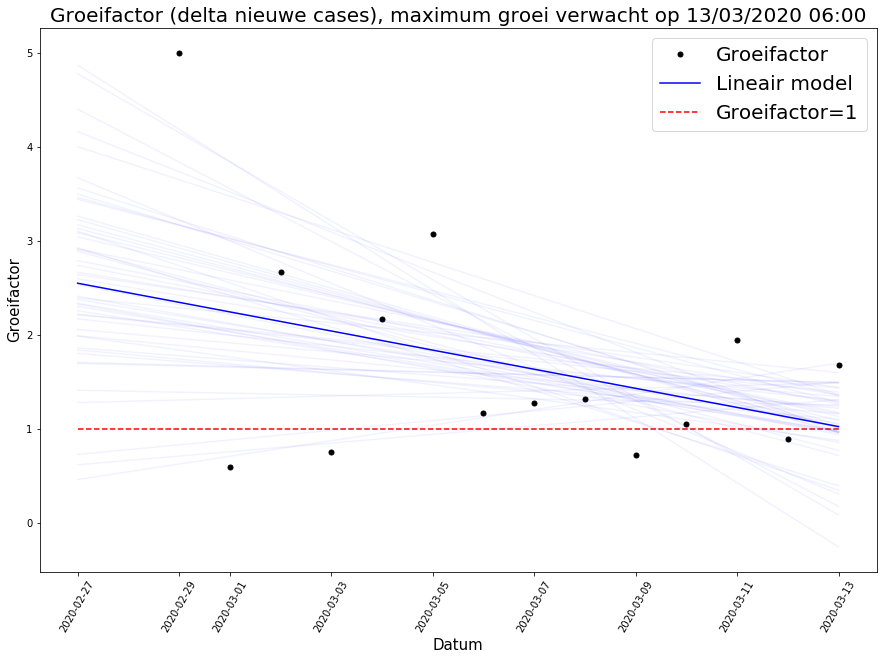

<Figure size 432x288 with 0 Axes>

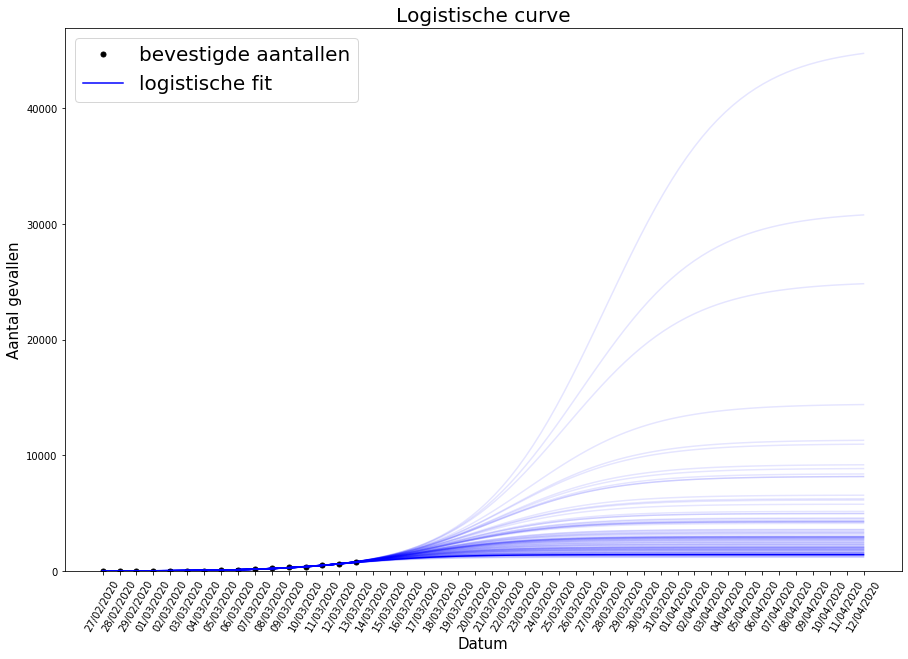

<Figure size 432x288 with 0 Axes>

In [196]:
if __name__ == "__main__":

    df = read_data()

    df = add_variables(df)

    intercepts, coefficients = analyze_growth_factor(df)

    inflection_x, inflection_date = compute_inflection_point(df, intercepts, coefficients)

    print("Inflection expected after {:.1f} days, at date {:%d/%m/%Y %H:00}".format(inflection_x, inflection_date))

    create_growthfactor_plot(df, intercepts, coefficients, inflection_date)

    fitted_sigmoid = fit_sigmoid(df)
    
    fitted_sigmoids = fit_sigmoid_repeated(df)

    plot_sigmoids(df, fitted_sigmoid, fitted_sigmoids, extrapolate_days=30)